<a href="https://colab.research.google.com/github/lukasdekanovsky/Become_PythonDeveloper_AI/blob/main/REKURENT_(1D_CNN)_Tvorba_AI_zvukov%C3%A9_stopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rekurentní síť pro generování hudby - predikce dalších tónů**

https://www.tensorflow.org/tutorials/audio/music_generation

* Program se naučí z dané sekvence not odvodit další notu
* Opakováním kódu můžeme generovat delší zvukové sekvence

# 1) **Import knihoven a doprovodných balíčků**
* pyfluidsynth = generuje audio playback v colabu
* pretty_midi = knihovna pro tvorbu a parsování MIDI souborů

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

* Základní parametry zvukové stopy

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# samplovací vzorek pro audio
_SAMPLING_RATE = 16000

# 2) **Stažení datasetu - maestro**

* Stažení zip file a jeho extrakce

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


* Získáváme mnoho zvukových stop v různých kategoriích, vše to jsou piano nahrávky - 1200 MIDI souborů

* Celkový počet zvukových stop v datasetu získáme: **glob.glob(data_dir/*/*.mid*)**



In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))
print(filenames[0])
# příklad první audio nahrávky
# data/maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--2.midi

Number of files: 1282
data/maestro-v2.0.0/2017/MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--2.midi


# 3) **Procesování MIDI nahrávek**

--> filenames = cesta k souboru

* použijeme pretty_midi k analyzování jedné MIDI nahrávky a prověříme formát

In [ ]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2017/MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--2.midi


* Generujeme si PrettyMIDI object - díky tomu můžeme přehrát

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

--> pm = PrettyMIDI obejkt nahrávky k přehráná
* Vytvoříme si funkci **display_audio**, kterou si můžeme přehrát nahrávku

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)


In [ ]:
display_audio(pm)

* Jaké nástroje jsou použity v nahrávkách ? **(pm.instruments)**

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


* extrakce dalších informací

--> (i) pořadí, (note_name) nota, (duration) trvání tonu

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=64, note_name=E4, duration=0.9344
1: pitch=60, note_name=C4, duration=0.9385
2: pitch=62, note_name=D4, duration=0.0698
3: pitch=59, note_name=B3, duration=0.0708
4: pitch=64, note_name=E4, duration=0.0427
5: pitch=60, note_name=C4, duration=0.0375
6: pitch=59, note_name=B3, duration=0.0646
7: pitch=62, note_name=D4, duration=0.0625
8: pitch=64, note_name=E4, duration=0.0385
9: pitch=60, note_name=C4, duration=0.0885


* celkem tedy získáváme 3 roměnné reprezentující tób během učení:
* 1) pitch - kvalita, nebo také tonina
* 2) step - čas od předešlé noty nebo začátku skladby
* 3) duration - jak dlouho daný tonn trvá

--> Zadefinujeme si funkci **midi_to_notes**
* do té vtupuje samotný midi_file: jako string

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,64,0.988542,1.922917,0.000000,0.934375
1,55,0.989583,2.350000,0.001042,1.360417
2,60,0.990625,1.929167,0.001042,0.938542
3,48,0.991667,2.350000,0.001042,1.358333
4,62,1.956250,2.026042,0.964583,0.069792


* převedeme pitch interpretaci na notu do vektoru **np.vectorize**

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E4', 'G3', 'C4', 'C3', 'D4', 'B3', 'E4', 'C4', 'B3', 'D4'],
      dtype='<U3')

# 4) **Vizualizace nahrávky**
* pomocí funkce **plot_piano_roll**


In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

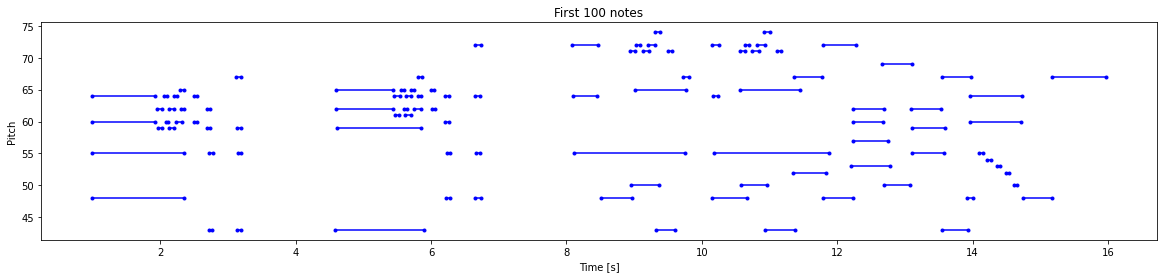

In [ ]:
plot_piano_roll(raw_notes, count=100)

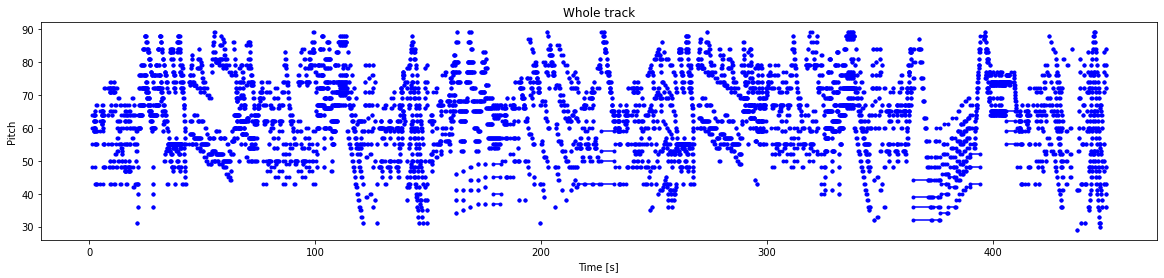

In [ ]:
plot_piano_roll(raw_notes)

* Zadefinujeme si funkci **plot_distributions** abychom prozkoumali distribuci

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

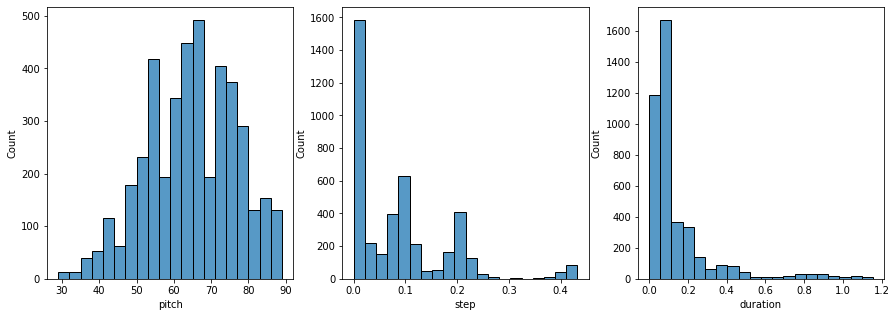

In [ ]:
plot_distributions(raw_notes)

# 5) **Funkce pro tvorbu MIDI**

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

# 6) **Tvorba tréninkového datasetu**

* dataset trénovací vytvoříme extrakcí notes z MIDI souboru

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 22540


* dále vytvoříme trénovací dataset pomoci **tf.data.Dataset**

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5078125  0.         0.08541667]
 [0.515625   0.14583333 0.0375    ]
 [0.5078125  0.06770833 0.05625   ]
 [0.5234375  0.109375   0.04479167]
 [0.53125    0.07395833 0.05416667]
 [0.5390625  0.096875   0.059375  ]
 [0.53125    0.078125   0.05      ]
 [0.546875   0.07291667 0.04583333]
 [0.5546875  0.08645833 0.05      ]
 [0.5625     0.10416667 0.071875  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=68.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.017708333333333215>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.4677083333333334>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# 7) **Tvorba a trénink modelu**


In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

351/351 [==============================] - 17s 35ms/step - loss: 5.0072 - duration_loss: 0.1276 - pitch_loss: 4.8508 - step_loss: 0.0289


{'loss': 5.007235050201416,
 'duration_loss': 0.1275939792394638,
 'pitch_loss': 4.850761413574219,
 'step_loss': 0.028881369158625603}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

351/351 [==============================] - 9s 22ms/step - loss: 0.3990 - duration_loss: 0.1276 - pitch_loss: 4.8508 - step_loss: 0.0289


{'loss': 0.3990134596824646,
 'duration_loss': 0.1275939792394638,
 'pitch_loss': 4.850761413574219,
 'step_loss': 0.028881369158625603}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
351/351 [==============================] - 20s 50ms/step - loss: 0.3136 - duration_loss: 0.0803 - pitch_loss: 4.1155 - step_loss: 0.0275
Epoch 2/50
351/351 [==============================] - 17s 49ms/step - loss: 0.2975 - duration_loss: 0.0751 - pitch_loss: 3.9355 - step_loss: 0.0256
Epoch 3/50
351/351 [==============================] - 14s 40ms/step - loss: 0.2932 - duration_loss: 0.0733 - pitch_loss: 3.8903 - step_loss: 0.0254
Epoch 4/50
351/351 [==============================] - 15s 44ms/step - loss: 0.2910 - duration_loss: 0.0728 - pitch_loss: 3.8622 - step_loss: 0.0251
Epoch 5/50
351/351 [==============================] - 15s 43ms/step - loss: 0.2884 - duration_loss: 0.0717 - pitch_loss: 3.8338 - step_loss: 0.0251
Epoch 6/50
351/351 [==============================] - 21s 61ms/step - loss: 0.2866 - duration_loss: 0.0709 - pitch_loss: 3.8198 - step_loss: 0.0247
Epoch 7/50
351/351 [==============================] - 18s 51ms/step - loss: 0.2848 - duration_loss: 0.0697 - pit

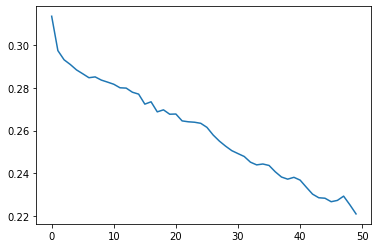

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# 8) **Generování not**

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 23ms/step


In [ ]:
generated_notes.head(120)

,pitch,step,duration,start,end
0,59,0.131062,1.357450,0.131062,1.488512
1,68,0.257980,0.894466,0.389042,1.283508
2,85,0.254754,0.591544,0.643795,1.235340
3,47,0.232034,0.508497,0.875829,1.384326
4,81,0.244863,0.054933,1.120692,1.175625
...,...,...,...,...,...
115,76,0.288746,0.483119,32.325989,32.809109
116,49,0.287493,0.481318,32.613482,33.094799
117,86,0.288450,0.092946,32.901932,32.994878
118,81,0.279495,0.529134,33.181427,33.710561


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Vygenerovaná hudba

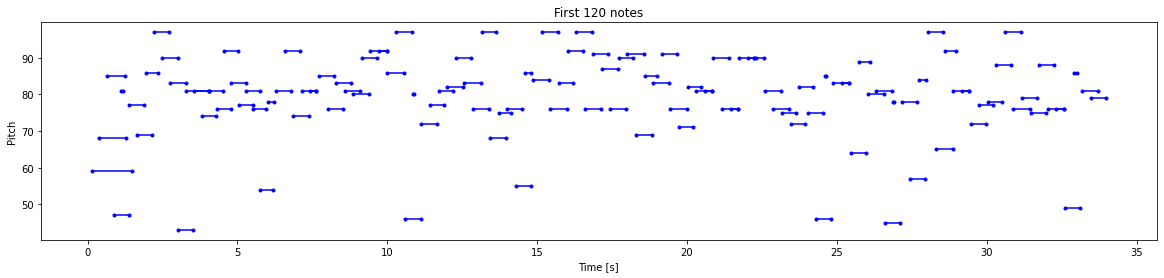

In [ ]:
raw_notes2 = midi_to_notes(out_file)
plot_piano_roll(raw_notes2, count=120)